<a href="https://colab.research.google.com/github/flaerni/AIProject/blob/master/ProjectHandIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Technologies 2019

##  Student Project by Kumulil Kiran, Gonzalez Avilés Ruben Octavio, Aerni Florian



## Introduction

A insurance company registered, that the eligibility assessment of applicants varied, depending on which employee assessed it. In order to harmonize the decision and maybe improve the decision finding process, the insurance company decided to implement a computer based system that consists of three parts:

### 1. A decision-based system 
For the decision based system the human experts doing the assesments thus far were interviewed. The findings were formulated into written rules, these rules are the basis for the system.

### 2. A Machine Learning-based system
With the idea to maybe uncover hidden factors, we let a Neural Network (NN) to process data derived from past cases. A first goal is to train the NN, so that it can reproduce a decision when given a test case. In a further step, we try to derive, whether we focus on the right factors or if additional insight can be gained and injected into the decision making.

### 3. The combination of the both systems
Both systems are of relevance, but they might produce variying weightings in assessment. If the insights gained from the NN point in another direction than the decision-based system, we have to look carefully into these results. Further, both systems could produce insights valuable for refining the other tool and highlighting important factors.



## 1. A decision-based System

### Formalizing the knowledge
We first take a step back and have a look in which context this system is supposed to be active:
An Applicant enters their data over a webpage. This data then is translated into the knowledge based system, where it is assessed. The trigger to assess the data will most probably be automated, for simplicity reason we here assume that an employee will manually execute the assessment.

We have to bring the data derived from expert interviews into a format a machine can make us of. As an intermediate step, we translated the text-form results into a decision table:

#### Decision Table Expert Knowledge
https://drive.google.com/file/d/1ZiuXdyh2DM_yBvQFejp_SVModPjLILV9/view?usp=sharing

![decision table](https://i.ibb.co/1bsSMC4/DTexpert-Knowledge.jpg)



### The Prolog Program

Starting from the decision table, we started to build a formalized version, namely in Prolog code. To simulate the first steps in the scenario, namely the data entry into the knowledge system, we created two ficitious customers named "Dan" and "Peter". For now the name serves as identifier, in runtime a unique identifier would have to be defined, for example an assigned applicant number.

In this first attempt to formalize the rules as far as possible, there still was an uncertainty left about the relation between eligibility and the risk status. It was first interpreted, that risk status is not the output variable, rather part of the input, and the decision Eligible/Eligible with fee/not Eligible is asked for, thus the first version put out these. For the sake of completeness, this version can be found here:
https://drive.google.com/file/d/15jV8mw57pn7DaAWkugTG31JrCkh4xaDN/view?usp=sharing
These uncertainties later were resolved by clarification through our Expert (Prof. Dr. Holger Wache). The three risk status are synonym with the three eligibility status, thus the risk status is already the output and not considered part of the input. A new and final version of the Prolog Code was developed:

#### Final Protoype Decision-Based System in Prolog
https://drive.google.com/file/d/1g8Te671_lnGxFPUpNLUgxdAxHQQSG_c3/view?usp=sharing


We here briefly provide insight about the functionality of the program sections, in addition to what is commented in the code itself:

- The first section "Facts" is purely the simulation of the data input by the customers. 

- The section "Basic rejection argument" is checking the two basic guidlines for immediate rejection (Applicant not resident in Switzerland, Applicant younger than 21 or older than 70).

- The section "Risk evaluation" is the core section of the program, where an applicant fulfilling basic requirements is acutally assessed. It is all pretty straight forward, checking the conditions described in the decision table. We here would like to point out "not_special_factors()", which is in the negated for for easier understanding - it makes use of the "\+" for negation in prolog. Also, the two last predicates incorporate the inequation 4=5 to reverse when fireing, because we want to return "true" when the risk is medium (see last bullet point for detail)

- A word about the "counting function", which turned out to be a piece de resistance. It took quite some experimenting and research online before we found a working way, making use of two prolog predicates length() and findall(). In our case, we exlusively use the function for counting the number of diseases, thus we hardcoded has_disease() in the counter. The way our counter works is as following: the method takes in a name (unique identifier of records) as well as the empty variable "Count". We pass the name into the findall predicate, which produces a list X, containing all cases of predicates being true with the given Name and any disease ("_" is passed as placeholder). After that, we use the length() method to pass the lenght of the list into the Count variable, which then will be given out to the caller of count(). Et voilà, disease counter.

- To simplify the evaluation, the different checks are summarized in "is_eligible(NAME)". This is the call/query an employee would execute (prolog code: ?-is_eligible(peter).). It puts out the eligibility result, i.e. the risk status. We decided that the result should "true", when the candidate is either eligible or eligible with a risk compensation and therefore only "false" when the candidate is rejected. In any case one of the special factors fires, we provide an additional explenation making use of the "write()" functionality.



## 2. A Machine Learning-based System

From past cases, we are provided with a dataset containing the following information to each case:

- age
- surgery 
- docvisit
- allergy
- medication
- disease
- bmi
----
- class (output variable)

Making use of the "Keras" library in the python programming universe, we set up train a neural network in a "Google Colaboratory". We here show the program, complemented with descriptions on functionality and what our design decisions are based on, guiding the reader through the process.

#### Final Machine Leaning-based System for knowledge extraction


- **Loading the data**


We import the data for the project and store it in a pandas dataframe. We then display the first five rows of the dataframe for visualization purposes. Also we will import all relevant libraries for our project.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf 
import numpy as np


df = pd.read_csv("/content/drive/My Drive/InsuranceData.csv")

print (df.head())

   age  surgery  docvisit allergy medication      disease  bmi class
0   20        0         2      no         no  cholesterol   28   low
1   21        0         4      no         no           no   23   low
2   22        0         3      no         no           no   23   low
3   23        0         3      no         no           no   23   low
4   24        0         3      no         no           no   21   low


- **Normalizing the data**

We start normalizing the data by replacing string values with integers. After that, we convert the whole table to floating point values. Since we are working with categorical data in column "disease", we need to split the column in three more columns (= the number of values). The reason for that is, there is no expected hierarchy within the different diseases, but simply replacing them with placeholder numbers (1,2,3) could imply so for the network.
![normalizing categorical data](https://i.ibb.co/XpRKJHf/Screenshot-2019-10-20-at-11-25-31.png)

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df['allergy'] = df['allergy'].replace(['no'], 0)
df['allergy'] = df['allergy'].replace(['yes'], 1)


df['medication'] = df['medication'].replace(['no'], 0)
df['medication'] = df['medication'].replace(['yes'], 1)

df['cholesterol'] = np.where(df['disease'].str.contains('cholesterol'), 1, 0)
df['diabetes'] = np.where(df['disease'].str.contains('diabetes'), 1, 0)
df['heart'] = np.where(df['disease'].str.contains('heart'), 1, 0)
del df['disease']


df['class'] = df['class'].replace(['low'], 0)
df['class'] = df['class'].replace(['medium'], 1)
df['class'] = df['class'].replace(['high'], 2)


df = df.astype(float)
print (df.head())



    age  surgery  docvisit  allergy  ...  class  cholesterol  diabetes  heart
0  20.0      0.0       2.0      0.0  ...    0.0          1.0       0.0    0.0
1  21.0      0.0       4.0      0.0  ...    0.0          0.0       0.0    0.0
2  22.0      0.0       3.0      0.0  ...    0.0          0.0       0.0    0.0
3  23.0      0.0       3.0      0.0  ...    0.0          0.0       0.0    0.0
4  24.0      0.0       3.0      0.0  ...    0.0          0.0       0.0    0.0

[5 rows x 10 columns]


- **Understanding data**

To better understand what features are related how to the 'class' column, we will try to find a correlation between other values and the 'class' column. 
For visualization purposes we plot a correlation matrix and then we will also print out the correlation in an descending order to find out what features have the highest impact on the 'class' column.

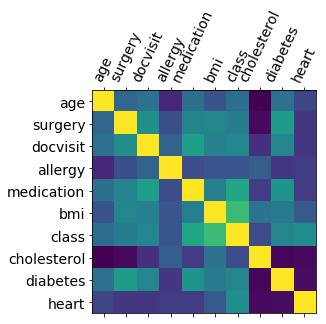


 Correlations:
bmi            0.619975
medication     0.507576
heart          0.394043
docvisit       0.352742
diabetes       0.351464
surgery        0.307645
age            0.238346
allergy        0.125123
cholesterol    0.082152
Name: class, dtype: float64


In [0]:
plt.matshow(df.corr())

plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=65)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
plt.show()

cm = df.corr()
cm = (cm['class'])

cm = cm.sort_values(ascending=False)
#first row is correlation of 'class' with 'class' which is 1.0 and therefore we can drop it
cm = cm.iloc[1:]
print ("\n","Correlations:")
print(cm)


From the results we can see that 'class' has a strong correlation with 'bmi' and 'medication' and a rather weak correlation with 'cholesterol' and 'allergy'.
Later we can also compare this results to the weighting, that our model assigned to the different input features.


- **Splitting and scaling data**

We now create a feature matrix called x_df and a target vector with the solutions called y_df.

In [0]:
x_df = df.drop('class',axis=1)
y_df = df['class']


We scale all values of the feature matrix in between 0 and 1 because our dataset contains features varying in magnitudes, units and range. We normalise the data here because the scale of features like bmi or age is irrelevant or misleading for our model.

In [0]:
x_df = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)

print (x_df.head())

        age  surgery  docvisit  allergy  ...       bmi  cholesterol  diabetes  heart
0  0.000000      0.0  0.111111      0.0  ...  0.571429          1.0       0.0    0.0
1  0.014706      0.0  0.222222      0.0  ...  0.214286          0.0       0.0    0.0
2  0.029412      0.0  0.166667      0.0  ...  0.214286          0.0       0.0    0.0
3  0.044118      0.0  0.166667      0.0  ...  0.214286          0.0       0.0    0.0
4  0.058824      0.0  0.166667      0.0  ...  0.071429          0.0       0.0    0.0

[5 rows x 9 columns]


Next we will convert the pandas dataframes into numpy arrays which will be the data for our machine learning model.

In [0]:
x_df_np = x_df.values
y_df_np = y_df.values

print(x_df_np)

[[0.         0.         0.11111111 ... 1.         0.         0.        ]
 [0.01470588 0.         0.22222222 ... 0.         0.         0.        ]
 [0.02941176 0.         0.16666667 ... 0.         0.         0.        ]
 ...
 [1.         0.5        1.         ... 0.         0.         0.        ]
 [1.         0.25       0.27777778 ... 0.         1.         0.        ]
 [1.         0.5        0.94444444 ... 0.         1.         0.        ]]


- **Creating the model with tensorflow**

We create a model with 3 outputs corresponding to the 'class' column in our target vector. ("low", "medium", "high") For the input layer we will use 9 values which is the number of columns in our feature matrix, namely:

age, surgery, docvisit, allergy, medication, bmi, cholesterol, diabetes, heart.

The System topography further contains two hidden layers, first of which with 128 elements and the second with 28 elements. This pretty shallow architecture has been choosen as of the small data set and the pretty limited amount of input variables; it has also been refined thorugh thorough trial-and-error investigation, randomly altering the structure and comparing results.


In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(9, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(28, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

- **Training the model with training data**

We split the data into 75% training data and 25% test data using the "validation_split" variable in the model.fit method and train the model with 50 epochs to avoid overfitting.

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_df_np, y_df_np, validation_split=0.25, epochs=50)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 87 samples, validate on 30 samples
Epoch 1/50
87/87 [==============================] - 0s 5ms/sample - loss: 1.0904 - acc: 0.4368 - val_loss: 1.0771 - val_acc: 0.5000
Epoch 2/50
87/87 [==============================] - 0s 218us/sample - loss: 1.0649 - acc: 0.5172 - val_loss: 1.0368 - val_acc: 0.5333
Epoch 3/50
87/87 [==============================] - 0s 209us/sample - loss: 1.0372 - acc: 0.4828 - val_loss: 0.9994 - val_acc: 0.5333
Epoch 4/50
87/87 [==============================] - 0s 208us/sample - loss: 1.0143 - acc: 0.5172 - val_loss: 0.9619 - val_acc: 0.5333
Epoch 5/50
87/87 [==============================] - 0s 158us/sample - loss: 0.9946 - acc: 0.5517 - val_loss: 0.9309 - val_acc: 0.6000
Epoch 6/50
87/87 [==============================] - 0s 155us/sample - loss: 0.9776 - acc: 0.5517 - val_loss: 0.9051 - val_acc: 0.6667
Epoch 7/50
87/87 [==============================] - 0s 157us/sample - los

- **Visualization of results**

We plot the historical data of the model using the matplot library. We create two charts to show how accuracy and loss improved with the number of epochs. Then we also print out the accuracy and loss of the last validation result.

Further, we are printing out a summary of the model.


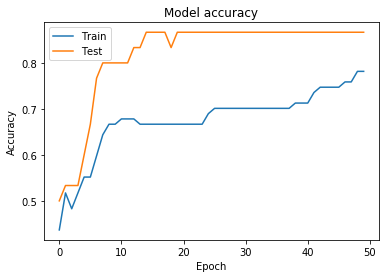

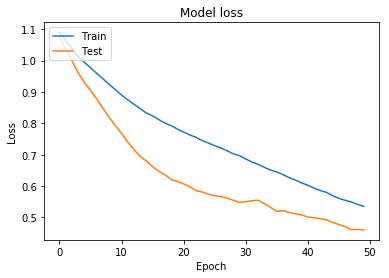

last accuracy:  [0.8666667]
last loss:  [0.4604187607765198] 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  90        
_________________________________________________________________
dense_1 (Dense)              multiple                  1280      
_________________________________________________________________
dense_2 (Dense)              multiple                  3612      
_________________________________________________________________
dense_3 (Dense)              multiple                  87        
Total params: 5,069
Trainable params: 5,069
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("last accuracy: ",history.history['val_acc'][-1:])
print("last loss: ",history.history['val_loss'][-1:], "\n")


model.summary()

- **Weightings**

We want to find out to which of our input features our model gave the highest weighting. We do this by getting the weightings from the model after the training and plotting it using a horizontal bar chart. 

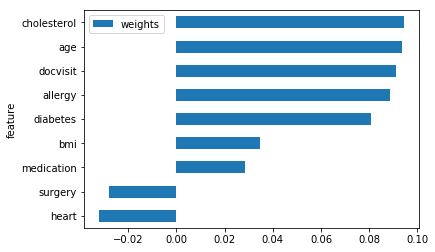

In [0]:
p = model.layers[0].get_weights()

weights = (p[-1:][0])

wf = pd.DataFrame()
wf = wf.assign(weights = weights)
wf = wf.assign(feature = x_df.columns)

wf = wf.sort_values(by=['weights'])

ax = wf.plot.barh(x='feature', y='weights')


## 3. The combination of the both systems

For the combination of the machine learning insights and the expert knowledge into the rule based system, we compare the insights gained from the machine-learning analysis with the insights gained from the expert interviews.

### Presence

From the results of the analysis using the neural network, we learned that additional factors to what was derived from the expert interviews potentially bear a greater influence than assumed. Thus, it is worth considering amending the rule-based system accordingly. 
Our recommendation is to organize a consortium, including experienced risk assessment experts, business analysts and also data analysts, to evaluate the statistical and commercial impact of these variations. If a factor is deemed worth considering in the application process, it is incorporated into the rule-based system before it goes live.


### Outlook and recommendations

Naturally, society is always in movement and so are its members; and progress is produced in exhillirating speed. New and expensive treatments are developed continiously. Further, in very short periods of time, health insurance companies have to deal with treatment costs of illnesses not even discovered yet. And last but not least, the habits of members of the ever changing society influence their health as well.
All of this exhibits, that the performed analytic steps and translation into useful business systems cannot be an one-time event. Therefore, we propose a semi-automated approach with two main control processes:

**1. Periodic manual assessment of insights gained from machine learning analysis, compared with the current runtime rule-based system.**

We recommend a scheduled, periodic review/repetition of the data analysis making use of the neural network. The idea here is to basically repeat the process documented in this dossier and refine the deployed system with newly gained insights based on more recent data.
Further, we strongly recommend to include further applicant data into the machine learning part, such as *treatment cost(!), area of profession, addiction history and level of activity (sports)*. Incorporating the cost level and more variables that are expected to have great influence on the cost level will greatly improve the value the system generates for the company.
As a general rule we recommend a review every semester or every year, in order to detect longterm trends and be able to react proactively.



**2. Dynamic monitoring of rule-based system in real time**

The second measure we propose is thought as an alert system for sudden changes with great impact.
For this scenario, we imagine a cardiac pacemaker that was implanted frequently a few years ago and now starts to fail frequently. This development might be fast enough to evade the periodic assessment, but could potentially be of great impact for projected cost with new applicants (i.e. accepted applicants causing immediate high costs after being accepted).
To cover this scenario, we propose to deploy the trained neural network in a parent system overviewing the rule-based system in application. This overarching system is automatically feeding the neural network with recent data and comparing them to the current factors and weightings in the decision-based system (numeric values would have to be assigned). If the deviation between the calculated value for a factor is greater than a defined number, e.g. >= 0.5, then a special alert is issued to the authority responsible for the applications, which has to assess the deviation. 



## A students perspective

Retrospectively, this project was very insightful on where the pitfalls lay, both on the rule-based part and the machine-learning part. We here provide some insights on where we faced difficulties and what we think can be done in the future to avoid similar obstacles.


### Rule-based System

In this part, we faced two major difficulties. 
First, undersanding the concepts of the programming language Prolog was challanging. All uf us are native in the object-based language "Java". Especially to understand, how the predicates in prolog do and especially do not compare to the functions in Java.
Second, as previously mentioned, we first struggeled with the interpretation of the natural language form the expert knowledge and the task description was recorded in. We had to learn how crucial it is to be able to understand what the initiator wants. Already the slightest missunderstanding might impact the outcome of such a logic system severely. The gained insight here is, that in a fully fletched business scenario a written project definition/instruction is not enough. Recurring exchanges between the system architects/programmers and the experts/project sponsors has to take place, in order to clear possible missunderstandings.


### Machine-learning Sytem

From the machine-learning part, we don't have to report difficulties in that sense, but rather capture important factors we learned to pay close attention too.
First, working in Google Colab was a very good experience. This tool greatly enhanced the group work on the machine-learning part.
Second, the direct relation of the input data with the input layer of the network needs to be considered very carefully. In the process of refining the network, we normalized the data in three intervals on three points of time. Every time, we had to carefully match the network to the changes in the input data set for it to produce meaningful results. An example of that is the normalization of the "disease"-column into three columns "heart", "diabetis" and "cholesterol" which resulted in an increase in input neurons.
Third, at the beginning we tended to overfit the model, i.e. set too many layers and epochs. The insight is, that in machine-learning the Slogan "the more the better" does not apply.


